# Which Company brings more revenue?
## Introduction 

The telecom operator Megaline company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

A preliminary analysis of the plans based on a relatively small client selection is carried out. This analysis uses the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. This project analyze the clients' behavior and determine which prepaid plan brings in more revenue.


In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
from scipy import stats as st
import os
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [4]:
# Load the data files into different DataFrames
df_call=pd.read_csv("megaline_calls.csv")
df_message=pd.read_csv("megaline_messages.csv")
df_internet=pd.read_csv("megaline_internet.csv")
df_user=pd.read_csv("megaline_users.csv")
df_plan=pd.read_csv("megaline_plans.csv")  

## Prepare the data

## Plans

In [5]:
# Print the general/summary information about the plans' DataFrame
df_plan.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Print a sample of data for plans
df_plan.head(5)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


### Data about Users

In [5]:
# Print the general/summary information about the users' DataFrame
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [6]:
# Print a sample of data for users
df_user.head(5)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [7]:
# change data type
df_user["reg_date"]=pd.to_datetime(df_user["reg_date"])

In [8]:
df_user["churn_date"]=pd.to_datetime(df_user["churn_date"])


In [9]:
# check missing values
df_user.isnull().sum()

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

In [10]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Enrich Data

In [11]:
# get churn_month and reg_month from churn_date and reg_date respectively
df_user["month"]=df_user["reg_date"].dt.month
df_user["churn_month"]=df_user["churn_date"].dt.month

## Calls

In [12]:
# Print the general/summary information about the calls' DataFrame
df_call.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [13]:
# Print a sample of data for calls
df_call.head(5)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


Call_date column is in object dtype, so change them to date type

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [14]:
# change call_date date type to date type
df_call["call_date"]=pd.to_datetime(df_call["call_date"])

### Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [15]:
df_call["month"]=df_call["call_date"].dt.month

In [16]:
# round up duration to minutes
def round_up(duration):
    seconds=duration*60
    if seconds%60==0:
        return duration
    return np.ceil(duration)

In [17]:
# apply round up function
df_call["duration"]=df_call["duration"].apply(round_up)

In [18]:
df_call.head(5)

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9.0,12
1,1000_145,1000,2018-12-27,14.0,12
2,1000_247,1000,2018-12-27,15.0,12
3,1000_309,1000,2018-12-28,6.0,12
4,1000_380,1000,2018-12-30,5.0,12


<div class="alert alert-success" role="alert">
<b>Reviewer's comment v2:</b>
    
- Ok, great job! You can also use here np.ceil () function.

- This function by the way also works without `apply` which makes code shorter and faster.

```
calls['duration'] = np.ceil(calls['duration'])
```

## Messages

In [19]:
# Print the general/summary information about the messages' DataFrame
df_message.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [20]:
# Print a sample of data for messages
df_message.head(5)

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


message_date is given in object type, so change it to date type

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [21]:
# change the given column to date type
df_message["message_date"]=pd.to_datetime(df_message["message_date"])

### Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [22]:
# get month of message_date
df_message["month"]=df_message["message_date"].dt.month

## Internet

In [23]:
# Print the general/summary information about the internet DataFrame
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [24]:
# Print a sample of data for the internet traffic
df_internet.head(5)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


 session_date is given as object type, so change it to date data type.

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [25]:
# change the given column to datetime type
df_internet["session_date"]=pd.to_datetime(df_internet["session_date"])

### Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [26]:
# Get session month from session date
df_internet["month"]=df_internet["session_date"].dt.month

## Study plan conditions

[It is critical to understand how the plans work, how users are charged based on their plan subscription. So, we suggest printing out the plan information to view their conditions once again.]

In [27]:
# Print out the plan conditions and make sure they are clear for you
df_plan.head(5)


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


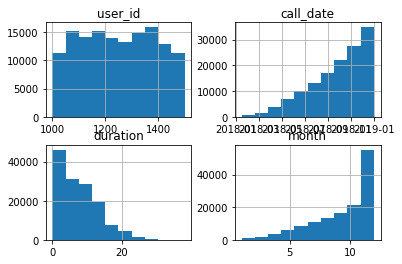

In [28]:
# check data
df_call.hist()
plt.show()

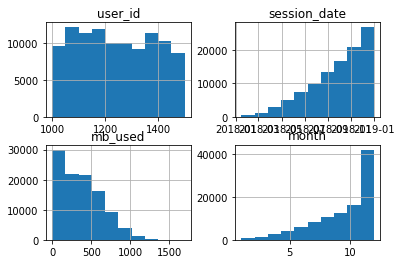

In [29]:
# check internet data
df_internet.hist()
plt.show()

<div class="alert alert-success">
<b>Reviewer's comment v1:</b>
    
Good start and first view on data! 

Additionally would be great to double-check the internet data and calls - are there any strange things (missing/zero values, for example)? It is very useful to always check the numerical data. Sometimes it is difficult due to a large amount of data, but after that, we have an idea of the data quality and existent issues with the data. You can easily check this data, for example, by creating histograms.

## Aggregate data per user

[Now, as the data is clean, aggregate data per user per period in order to have just one record per user per period. It should ease the further analysis a lot.]

<div class="alert alert-danger">
<b>Reviewer's comment v1:</b>
    
- Please note that the telecom operator rounds up all minutes and traffic values.

`Note: Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.`

Can you please add data rounding?

student comment: I rounded call data in df_call section above.

In [30]:
# Calculate the amount of minutes spent by each user per month. Save the result.

call_per_user_month=df_call.pivot_table(index = ('user_id','month'), values = 'duration', aggfunc = ('count','sum')).reset_index()

In [31]:
# change columns name 
call_per_user_month.rename(columns={"count":"call_count","sum":"total_duration"},inplace=True)

In [32]:
call_per_user_month.columns

Index(['user_id', 'month', 'call_count', 'total_duration'], dtype='object')

In [33]:
# creating avg_call_duration of each user
call_per_user_month["avg_call_duration"]=round(call_per_user_month["total_duration"]/call_per_user_month["call_count"],2)

In [34]:
call_per_user_month.head(5)

,user_id,month,call_count,total_duration,avg_call_duration
0,1000,12,16,124.0,7.75
1,1001,8,27,182.0,6.74
2,1001,9,49,315.0,6.43
3,1001,10,65,393.0,6.05
4,1001,11,64,426.0,6.66


<div class="alert alert-warning">
<b>Reviewer's comment v1:</b>
    
- In pivot_table or groupby it is possible to pass multiple arguments, so here, you can create an aggregated table in one go like this:

```
data_calls.groupby(['user_id','month']).agg({'duration' : ('count','sum')}).reset_index()
```

or

```
data_calls.pivot_table(index = ('user_id','month'), values = 'duration', aggfunc = ('count','sum')).reset_index()
```

In [35]:
# Calculate the number of messages sent by each user per month. Save the result.
message_by_user_month=df_message.pivot_table(index=("user_id","month"),values="id",aggfunc="count").reset_index()
message_by_user_month.head(5)

,user_id,month,id
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36


In [36]:
# change column names
message_by_user_month.rename(columns={"id":"number_of_messages"},inplace=True)

In [37]:
message_by_user_month

,user_id,month,number_of_messages
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [38]:
df_internet.head(5)

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


In [39]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
mb_by_user_month=df_internet.pivot_table(index=("user_id","month"),values="mb_used",aggfunc=("count","sum")).reset_index()
mb_by_user_month.head(5)

,user_id,month,count,sum
0,1000,12,5,1901.47
1,1001,8,25,6919.15
2,1001,9,53,13314.82
3,1001,10,56,22330.49
4,1001,11,51,18504.30


In [40]:
# renaming column names
mb_by_user_month.rename(columns={"count":"num_of_session","sum":"total_mb_used"},inplace=True)

In [41]:
# rounding mb
def round_up_mb(mb_used):
    if mb_used%1024==0:
        return mb_used
    return np.ceil(mb_used)

In [42]:
# apply rounding up function for mb_used
mb_by_user_month["total_mb_used"]=mb_by_user_month["total_mb_used"].apply(round_up_mb)

In [43]:
# creating new column average_mb_used
mb_by_user_month["avg_mb_used"]=round(mb_by_user_month["total_mb_used"]/mb_by_user_month["num_of_session"],2)

In [44]:
mb_by_user_month.head(5)

,user_id,month,num_of_session,total_mb_used,avg_mb_used
0,1000,12,5,1902.0,380.40
1,1001,8,25,6920.0,276.80
2,1001,9,53,13315.0,251.23
3,1001,10,56,22331.0,398.77
4,1001,11,51,18505.0,362.84


In [45]:
message_by_user_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   user_id             1806 non-null   int64
 1   month               1806 non-null   int64
 2   number_of_messages  1806 non-null   int64
dtypes: int64(3)
memory usage: 42.5 KB


In [46]:
call_per_user_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            2258 non-null   int64  
 1   month              2258 non-null   int64  
 2   call_count         2258 non-null   int64  
 3   total_duration     2258 non-null   float64
 4   avg_call_duration  2258 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 88.3 KB


[Put the aggregate data together into one DataFrame so that one record in it would represent what an unique user consumed in a given month.]

In [47]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
df_combined =call_per_user_month.merge(message_by_user_month[["user_id","number_of_messages"]],how="left",left_on="user_id",right_on="user_id")


In [48]:
df_combined=df_combined.merge(mb_by_user_month[["user_id","num_of_session","total_mb_used"]],how="left",left_on="user_id",right_on="user_id")

In [49]:
df_user.columns

Index(['user_id', 'first_name', 'last_name', 'age', 'city', 'reg_date', 'plan',
       'churn_date', 'month', 'churn_month'],
      dtype='object')

In [50]:
df_combined=df_combined.merge(df_user[["user_id","first_name","last_name","age","city","reg_date","plan","churn_date",
"churn_month"]],how="left",left_on="user_id",right_on="user_id")

In [51]:
df_combined.head(5)

,user_id,month,call_count,total_duration,avg_call_duration,number_of_messages,num_of_session,total_mb_used,first_name,last_name,age,city,reg_date,plan,churn_date,churn_month
0,1000,12,16,124.0,7.75,11.0,5.0,1902.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,NaN
1,1001,8,27,182.0,6.74,30.0,25.0,6920.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,NaN
2,1001,8,27,182.0,6.74,30.0,53.0,13315.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,NaN
3,1001,8,27,182.0,6.74,30.0,56.0,22331.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,NaN
4,1001,8,27,182.0,6.74,30.0,51.0,18505.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,NaN


<div class="alert alert-danger">
<b>Reviewer's comment v1:</b>
    
Here you need to use another way of joining tables (change the how parameter, by default merge has how='inner'). Now, if users made calls, but did not send messages, it will not be tracked in the new table (the same with the Internet). This will happen because with the left method we take all the keys from the left table and look for their matches in the right table. If there are unique values in the right table, we will ignore them. For this task, we need to take all the records from the right and left tables. You can see about connections here https://medium.com/@Lexx01/sql-inner--outer-join-64f3862d8540

<div class="alert alert-block alert-success">
<b>Reviewer's comment v2:</b>
    
Here you can also use `how = 'outer' to prevent data loss.
    

In [52]:
# change plan to plan_name
df_combined.rename(columns={"plan":"plan_name"},inplace=True)

In [53]:
df_combined=df_combined.merge(df_plan,on="plan_name")

In [54]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88144 entries, 0 to 88143
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                88144 non-null  int64         
 1   month                  88144 non-null  int64         
 2   call_count             88144 non-null  int64         
 3   total_duration         88144 non-null  float64       
 4   avg_call_duration      88144 non-null  float64       
 5   number_of_messages     84804 non-null  float64       
 6   num_of_session         88080 non-null  float64       
 7   total_mb_used          88080 non-null  float64       
 8   first_name             88144 non-null  object        
 9   last_name              88144 non-null  object        
 10  age                    88144 non-null  int64         
 11  city                   88144 non-null  object        
 12  reg_date               88144 non-null  datetime64[ns]
 13  p

In [55]:
# changing month number to month name
import calendar
d = dict(enumerate(calendar.month_abbr))
df_combined['month'] = df_combined['month'].map(d)

[Calculate the monthly revenue from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan). N.B. This might not be as trivial as just a couple of lines given the plan conditions! So, it's okay to spend some time on it.]

In [56]:
# Calculate the monthly revenue for each user
def cal_revenue(row):
    """
    Calculate the revenue for each plan
    """
    (
        total_duration,
        number_of_messages,
        total_mb_used,
        messages_included,
        mb_per_month_included,
        minutes_included,
        usd_monthly_pay,
        usd_per_gb,
        usd_per_message,
        usd_per_minute
    ) = row
    additional_call_cost, additional_session_cost, additional_msg_cost = 0, 0, 0
    if total_duration > minutes_included:
        additional_call_cost = (total_duration - minutes_included) * usd_per_minute
    if total_mb_used > mb_per_month_included:
        additional_session_cost = ((total_mb_used - mb_per_month_included) / 1024) * usd_per_gb
    if number_of_messages > messages_included:
        additional_msg_cost = (number_of_messages - messages_included) * usd_per_message
    return round(usd_monthly_pay + additional_call_cost + additional_session_cost + additional_msg_cost,2)

In [57]:
columns_to_use = ['total_duration', 'number_of_messages', 'total_mb_used',
                'messages_included', 'mb_per_month_included', 'minutes_included',
                'usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute']
df_combined['cal_revenue'] = df_combined[columns_to_use].apply(cal_revenue, axis=1)

In [58]:
pd.set_option('display.max_columns',None)

<div class="alert alert-warning">
<b>Reviewer's comment v1:</b>
    
I see that some columns are hidden. It is possible to disable this and display all columns/rows with:

```python
pd.set_option ('display.max_columns', None)
```

<div class="alert alert-success">
<b>Reviewer's comment v1:</b>
    
Everything is correct here! Great, that you created a function to calculate revenue, but results will be a little bit different after data rounding. 
    
Btw it is also possible to make the calculation of revenue a little bit differently using np.where - [https://numpy.org/doc/stable/reference/generated/numpy.where.html](https://numpy.org/doc/stable/reference/generated/numpy.where.html)

```
  np.where ('condition: if exceeding the package limit', 'multiply the difference by the price of additional services', '0')
```
   

student comments: I was not able to use above way of findign revenue. Would please give me the idea on how to do it.

In [59]:
 # creating age group function
def age_groups(age):
    if age < 30:
        return '18-29 years'
    if age < 40:
        return '30-39 years'
    if age < 50:
        return '40-49 years'
    if age < 60:
        return '50-59 years'
    return '60+ years'

In [60]:
# creating age_group column
df_combined["age_groups"]=df_combined["age"].apply(age_groups)

In [61]:
df_combined["age_groups"].value_counts(normalize=True)

60+ years      0.267766
18-29 years    0.211245
40-49 years    0.191448
30-39 years    0.181816
50-59 years    0.147724
Name: age_groups, dtype: float64

60 plus group are the top age group

In [62]:
# df of each plan
df_surf=df_combined.query('plan_name=="surf"')
df_ultimate=df_combined.query('plan_name=="ultimate"')

In [63]:
# age group in surf plan
df_surf["age_groups"].value_counts(normalize=True)

60+ years      0.257632
18-29 years    0.229345
40-49 years    0.200367
30-39 years    0.167700
50-59 years    0.144956
Name: age_groups, dtype: float64

In [64]:
# age_group in ultimate plan
df_ultimate["age_groups"].value_counts(normalize=True)

60+ years      0.288662
30-39 years    0.210921
18-29 years    0.173927
40-49 years    0.173058
50-59 years    0.153432
Name: age_groups, dtype: float64

On both plans 60 plus age group have the top age group.
Age group of Surf plan is similar to the overall dataset.

In [65]:
print('Average duration of each user per month in Surf plan is {:.2f} minutes'.format(df_surf["total_duration"].mean()))
print('Average duration of each user per month in Ultimate plan is {:.2f} minutes '.format(df_ultimate["total_duration"].mean()))

Average duration of each user per month in Surf plan is 465.12 minutes
Average duration of each user per month in Ultimate plan is 443.71 minutes 


In [66]:
print('Average number of messages of each user per month in Surf plan is {:.2f} messages'.format(df_surf["number_of_messages"].mean()))
print('Average number of messages of each user per month in Ultimate plan is {:.2f} messages'.format(df_ultimate["number_of_messages"].mean()))

Average number of messages of each user per month in Surf plan is 37.63 messages
Average number of messages of each user per month in Ultimate plan is 45.74 messages


In [67]:
print('Average mb used by each user per month in Surf plan is {:.2f} mb'.format(df_surf["total_mb_used"].mean()))
print('Average mb used by each user per month in Ultimate plan is {:.2f} mb'.format(df_ultimate["total_mb_used"].mean()))

Average mb used by each user per month in Surf plan is 16870.76 mb
Average mb used by each user per month in Ultimate plan is 18620.65 mb


In [68]:
print('Average revenue of each user per month in Surf plan is $ {:.2f}'.format(df_surf["cal_revenue"].mean()))
print('Average revenue of each user per month in Ultimate plan is  ${:.2f}'.format(df_ultimate["cal_revenue"].mean()))

Average revenue of each user per month in Surf plan is $ 56.54
Average revenue of each user per month in Ultimate plan is  $73.04


In [69]:
# splitting city column 
new=df_combined["city"].str.split(",", n = 2, expand = True)

In [70]:
# city_new column is created that contains only city name 
df_combined["city_new"]=new[0]

In [71]:
# df of New York and New Jersy area
df_combined_NY_NJ = df_combined.query('city_new=="New York-Newark-Jersey City"')

In [72]:
# df of areas other than New York and New Jersy
df_combined_Other_Areas = df_combined.query('city_new!="New York-Newark-Jersey City"')

In [73]:
# Revenue of Other areas
df_combined_other_area_revenue=df_combined_Other_Areas["cal_revenue"]

In [74]:
# revenue of NY NJ
df_combined_NY_NJ_revenue=df_combined_NY_NJ["cal_revenue"]

## Study user behaviour

[Calculate some useful descriptive statistics for the aggregated and merged data, which typically reveal an overall picture captured by the data. Draw useful plots to help the understanding. Given that the main task is to compare the plans and decide on which one is more profitable, the statistics and the plots should be calculated on a per-plan basis.]

[There are relevant hints in the comments for Calls but they are not provided for Messages and Internet though the principle of statistical study is the same for them as for Calls.]

### Calls

In [75]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.
df_surf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59356 entries, 28788 to 88143
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                59356 non-null  int64         
 1   month                  59356 non-null  object        
 2   call_count             59356 non-null  int64         
 3   total_duration         59356 non-null  float64       
 4   avg_call_duration      59356 non-null  float64       
 5   number_of_messages     56973 non-null  float64       
 6   num_of_session         59292 non-null  float64       
 7   total_mb_used          59292 non-null  float64       
 8   first_name             59356 non-null  object        
 9   last_name              59356 non-null  object        
 10  age                    59356 non-null  int64         
 11  city                   59356 non-null  object        
 12  reg_date               59356 non-null  datetime64[ns]
 1

In [76]:
# average duration for each month
avg_duration_surf=df_surf.groupby("month")["total_duration"].mean()
avg_duration_ultimate=df_ultimate.groupby("month")["total_duration"].mean()

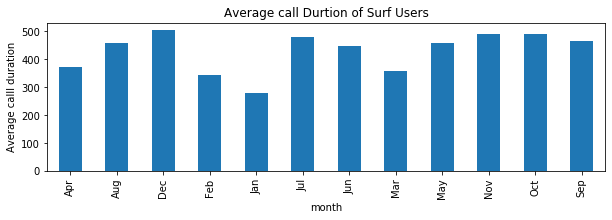

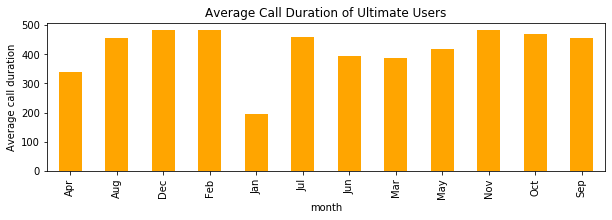

In [77]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.subplot(2, 1, 1) # row 1, col 2 index 1
avg_duration_surf.plot.bar()
plt.title("Average call Durtion of Surf Users")
plt.xlabel('month')
plt.ylabel('Average calll duration')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
plt.subplot(2, 1, 2) # index 2
avg_duration_ultimate.plot.bar(color="orange")
plt.title("Average Call Duration of Ultimate Users")
plt.xlabel('month')
plt.ylabel('Average call duration')
plt.show()

The average call duration of each user per month is similar in Surf and Ultimate plan.

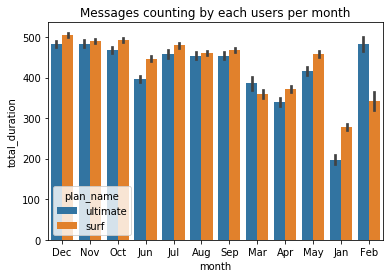

In [78]:
sns.barplot( y = "total_duration", x='month', data = df_combined, hue='plan_name')
plt.title('Messages counting by each users per month')
plt.show()


It shows that in most of the months Surf plan users used more messages than Ultimate plan users.

Surf plan users have longer call duration per month than Ultimate plan users.

In [79]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
# getting total minutes for each month
total_minutes_surf=df_surf.groupby("month")["total_duration"].sum()
total_minutes_ultimate=df_ultimate.groupby("month")["total_duration"].sum()

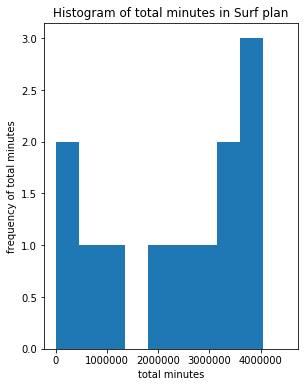

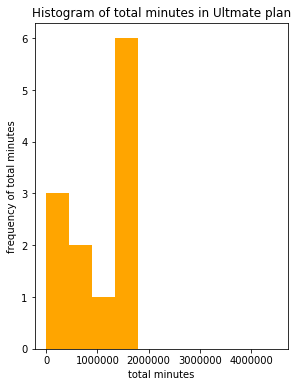

In [80]:
# histogram plot for each plan
fig, ax = plt.subplots(figsize=(10, 6))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
total_minutes_surf.plot.hist(range=(0,4500000))
plt.title("Histogram of total minutes in Surf plan")
plt.xlabel('total minutes')
plt.ylabel('frequency of total minutes')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
plt.subplot(1, 2, 2) # index 2
total_minutes_ultimate.plot.hist(range=(0,4500000),color="orange")
plt.title("Histogram of total minutes in Ultmate plan")
plt.xlabel('total minutes')
plt.ylabel('frequency of total minutes')
plt.show()

Surf plan users used more call minutes than Ultimate plan users.

[Calculate the mean and the variable of the call duration to reason on whether users on the different plans have different behaviours for their calls.]

In [81]:
# variance of the monthly call duration 
variance_monthly_duration_surf=df_surf.groupby("month")["total_duration"].var()
variance_monthly_duration_ultimate=df_ultimate.groupby("month")["total_duration"].var()

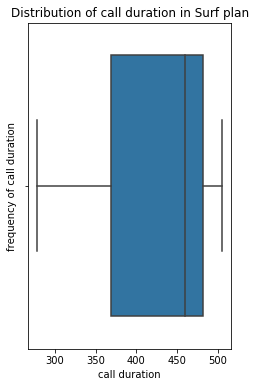

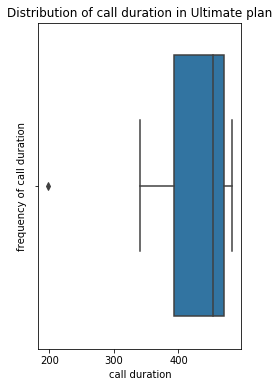

In [82]:
# Plot a boxplot to visualize the distribution of the monthly call duration
fig, ax = plt.subplots(figsize=(8, 6))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
sns.boxplot(x=avg_duration_surf)
plt.title("Distribution of call duration in Surf plan")
plt.xlabel('call duration')
plt.ylabel('frequency of call duration')
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
plt.subplot(1, 2, 2) # index 2
sns.boxplot(x=avg_duration_ultimate)
plt.title("Distribution of call duration in Ultimate plan")
plt.xlabel('call duration')
plt.ylabel('frequency of call duration')
plt.show()

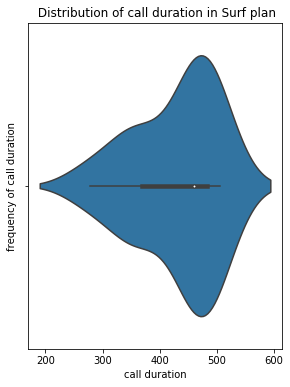

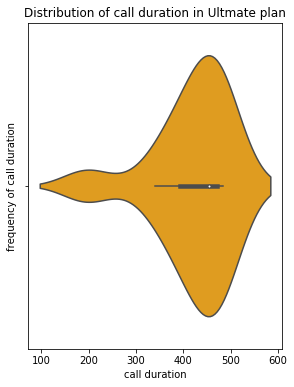

In [83]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
sns.violinplot(x=avg_duration_surf)
plt.title(" Distribution of call duration in Surf plan")
plt.xlabel('call duration')
plt.ylabel('frequency of call duration')

plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
plt.subplot(1, 2, 2) # index 2
sns.violinplot(x=avg_duration_ultimate,color="orange")
plt.title("Distribution of call duration in Ultmate plan")
plt.xlabel('call duration')
plt.ylabel('frequency of call duration')
plt.show()

Average call duration per each user per month is mostly concerntrated near 450 minutes. This average call duration is 
widely distributed between 100 minutes to 400 minutes in Surf plan whereas it is narrowly distributed in Ultimate plan.

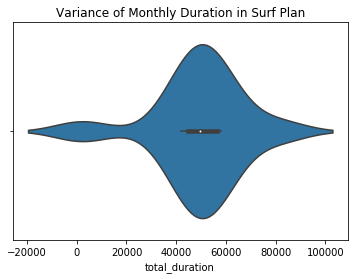

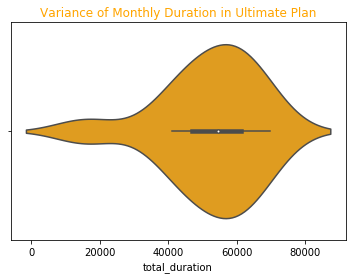

In [84]:
sns.violinplot(x=variance_monthly_duration_surf)
plt.title("Variance of Monthly Duration in Surf Plan")
plt.show()
sns.violinplot(x=variance_monthly_duration_ultimate,color="orange")
plt.title("Variance of Monthly Duration in Ultimate Plan",color="orange")
plt.show()

[Formulate conclusions on how the users behave in terms of calling. Is their behaviour different between the plans?]

Call duration time in Surf plan have few values that spread widely than in Ultimate plan. Call duration time around 6000
minutes in Ultimate plan have higher variance than in Surf plan.
It shows that in average Ultimate plan users have longer call duration than Surf plan users.

### Messages

In [85]:
# Compare the number of messages users of each plan tend to send each month
# messages in each plan in each month
avg_messages_month_surf=df_surf.groupby("month")["number_of_messages"].sum()
avg_messages_month_ultimate= df_ultimate.groupby("month")["number_of_messages"].sum()

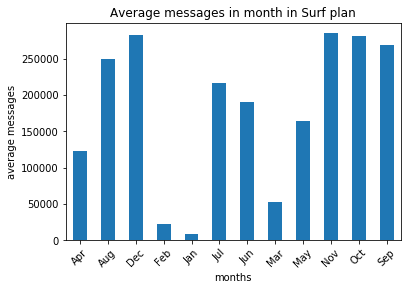

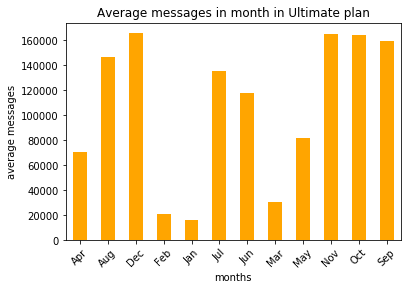

In [86]:
avg_messages_month_surf.plot.bar(rot=45)
plt.title("Average messages in month in Surf plan")
plt.ylabel("average messages")
plt.xlabel("months")
plt.show()
avg_messages_month_ultimate.plot.bar(rot=45,color="orange")
plt.title("Average messages in month in Ultimate plan")
plt.ylabel("average messages")
plt.xlabel("months")
plt.show()

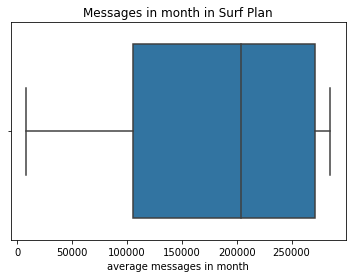

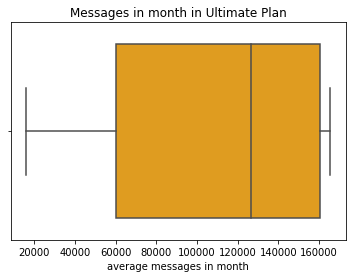

In [87]:
# boxplot of messages in each plan in each month
sns.boxplot(x=avg_messages_month_surf)
plt.title("Messages in month in Surf Plan")
plt.xlabel("average messages in month")
plt.show()
sns.boxplot(x=avg_messages_month_ultimate,color="orange")
plt.title("Messages in month in Ultimate Plan")
plt.xlabel("average messages in month")
plt.show()

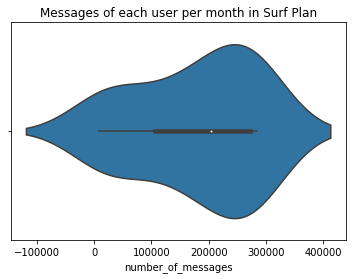

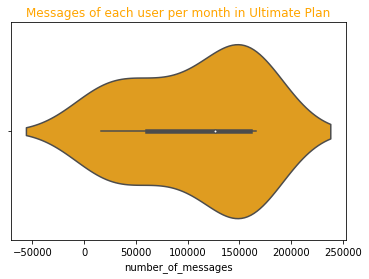

In [88]:
sns.violinplot(x=avg_messages_month_surf)
plt.title("Messages of each user per month in Surf Plan")
plt.show()
sns.violinplot(x=avg_messages_month_ultimate,color="orange")
plt.title("Messages of each user per month in Ultimate Plan",color="orange")
plt.show()

[Formulate conclusions on how the users behave in terms of messaging. Is their behaviour different between the plans?]

Users from both plans have used messages in similar pattern throughout 2018.
Median average number of messages in each month of Surf plan is higher than that of Ultimate plan.
Surf plan users have wider range in distribution of message usages.

### Internet

In [89]:
# Compare the amount of internet traffic consumed by users per plan

In [90]:
# df of each plan that have mb used in each month
total_mb_month_surf = df_surf.groupby("month")["total_mb_used"].sum()
total_mb_month_ultimate = df_ultimate.groupby("month")["total_mb_used"].sum()

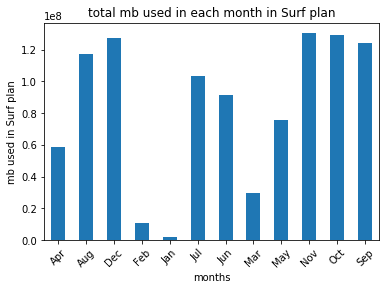

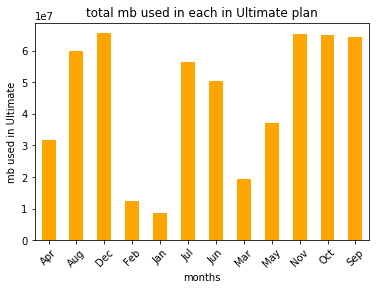

In [91]:
total_mb_month_surf.plot.bar(rot=45)
plt.title("total mb used in each month in Surf plan")
plt.ylabel("mb used in Surf plan")
plt.xlabel("months")
plt.show()
total_mb_month_ultimate.plot.bar(rot=45,color="orange")
plt.title("total mb used in each in Ultimate plan")
plt.ylabel("mb used in Ultimate")
plt.xlabel("months")
plt.show()

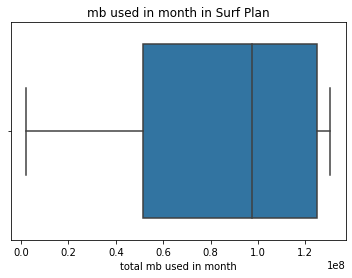

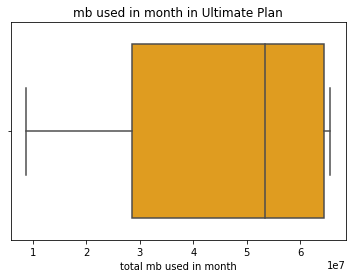

In [92]:
sns.boxplot(x=total_mb_month_surf)
plt.title("mb used in month in Surf Plan")
plt.xlabel("total mb used in month")
plt.show()
sns.boxplot(x=total_mb_month_ultimate,color="orange")
plt.title("mb used in month in Ultimate Plan")
plt.xlabel("total mb used in month")
plt.show()

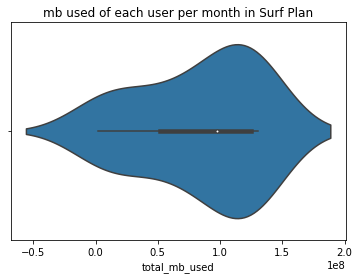

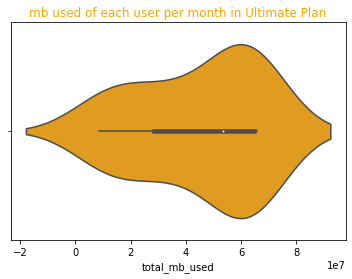

In [93]:
sns.violinplot(x=total_mb_month_surf)
plt.title("mb used of each user per month in Surf Plan")
plt.show()
sns.violinplot(x=total_mb_month_ultimate,color="orange")
plt.title("mb used of each user per month in Ultimate Plan",color="orange")
plt.show()

[Formulate conclusions on how the users tend to consume the internet traffic? Is their behaviour different between the plans?]

The pattern of mb used by both plan users are similar in each month in 2018.
Median mb used in each month in Surf plan is higher than in Ultimate plan.
Few users in Surf plan have few extreme lower and higher mb used values.

## Revenue

[Likewise you have studied the user behaviour, statistically describe the revenue between the plans.]

In [94]:
# df of revenue in each month in each plan
total_revenue_month_surf = df_surf.groupby("month")["cal_revenue"].sum()
total_revenue_month_ultimate = df_ultimate.groupby("month")["cal_revenue"].sum()

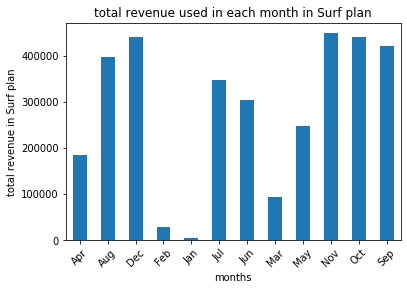

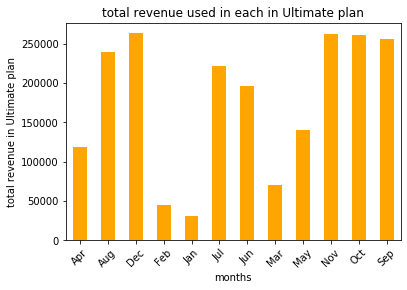

In [95]:
# bar plot of total revenue in each plan
total_revenue_month_surf.plot.bar(rot=45)
plt.title("total revenue used in each month in Surf plan")
plt.ylabel("total revenue in Surf plan")
plt.xlabel("months")
plt.show()
total_revenue_month_ultimate.plot.bar(rot=45,color="orange")
plt.title("total revenue used in each in Ultimate plan")
plt.ylabel("total revenue in Ultimate plan")
plt.xlabel("months")
plt.show()

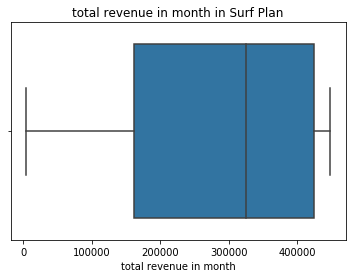

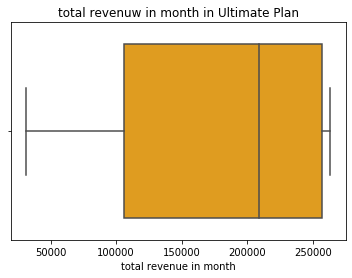

In [96]:
sns.boxplot(x=total_revenue_month_surf)
plt.title("total revenue in month in Surf Plan")
plt.xlabel("total revenue in month")
plt.show()
sns.boxplot(x=total_revenue_month_ultimate,color="orange")
plt.title("total revenuw in month in Ultimate Plan")
plt.xlabel("total revenue in month")
plt.show()

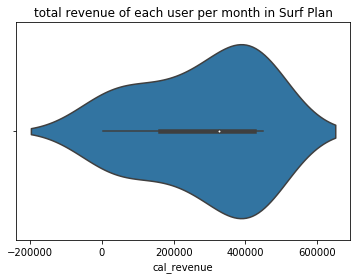

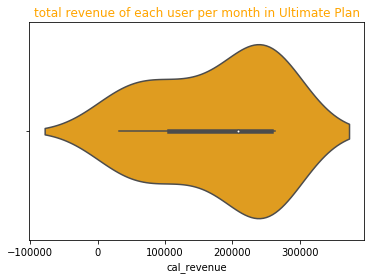

In [97]:
sns.violinplot(x=total_revenue_month_surf)
plt.title("total revenue of each user per month in Surf Plan")
plt.show()
sns.violinplot(x=total_revenue_month_ultimate,color="orange")
plt.title("total revenue of each user per month in Ultimate Plan",color="orange")
plt.show()

More revenue are collected from Surf plan users in 10 months out of 12 months. 
Total revenue of each month in Surf plan have higher median than in ultimate plan.
Surf plan users have few low and high extreme revenue values than that of Ultimate plan users.
In Surf plan, revenues of each per month is concerntrated neear 400000 dollars where as in Ultimate plan it is concerntrated near
250000 dollars.


[Formulate conclusions about how the revenue differs between the plans.]

<div class="alert alert-success">
<b>Reviewer's comment v1:</b>
    
- I will write overall thoughts about the data analysis section:
- Very nice visualisation of the data. Would be additionally great to combine both plans on one graph for the comparison and also used different graph types to check available data.
-  If you have time and willing to practice, you can display two charts (histogram and a boxplot) using a two-column subplot.

```
    # Create one row with 2 columns
	  fig, axes = plt.subplots(1, 2, figsize=(16, 5))

	  # Create a histogram for the surf plan
	  sns.distplot(... ax=axes[0])
	  # Create a histogram for the second plan
	  sns.distplot(... ax=axes[0])
	
	  # Create a boxplot for both plans
	  sns.boxplot(... ax=axes[1])
```

## Test statistical hypotheses

[Test the hypothesis that the average revenue from users of the Ultimate and Surf calling plans differs.]

[Formulate the null and the alternative hypotheses, choose the statistical test, decide on the alpha value.]

### hypothesis testing of revenue of two plans

Null hypothesis is mean revenue in each month in Surf plan is equal to mean revenue of Ultimate plan.

Alternative hypothesis is mean revenue in each month in Surf plan is not equal to mean revenue of Ultimate plan.

<div class="alert alert-warning">
<b>Reviewer's comment v1:</b>
 
- Can you please also formulate an alternative hypothesis in addition to the null hypotheses?

<div class="alert alert-success" role="alert">
<b>Reviewer's comment v2:</b>
    
🙌

In [98]:
# Test the hypotheses
mean_revenue_surf = df_combined[df_combined["plan_name"]=="surf"]["cal_revenue"].mean()
mean_revenue_ultimate = df_combined[df_combined["plan_name"]=="ultimate"]["cal_revenue"].mean()

alpha = 0.05 # your code: set a critical statistical significance level

results = st.ttest_ind(mean_revenue_surf, mean_revenue_ultimate)
# your code: test the hypothesis that the means of the two independent populations are equal

print('p-value:', results.pvalue) # your code: print the p-value you get

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")


p-value: nan
We can't reject the null hypothesis


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Test the hypothesis that the average revenue from users in the NY-NJ area is different from that of the users from the other regions.]

Since it is less expenxive to use Surf plan for getting similar service like Ultimate plan, it is better to use Surf plan.

### hypothesis testing of City areas

Null hypothesis: average revenue in NY-NJ area is equal to Other areas

Alternative hypothesis: average revenue in NY-NJ area is not equal to other areas

[Formulate the null and the alternative hypotheses, choose the statistical test, decide on the alpha value.]

In [99]:
# Test the hypotheses

alpha = 0.05 # your code: set a critical statistical significance level

results = st.ttest_ind(df_combined_NY_NJ_revenue, df_combined_other_area_revenue)
# your code: test the hypothesis that the means of the two independent populations are equal

print('p-value:', results.pvalue) # your code: print the p-value you get

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 7.382977766876453e-200
We reject the null hypothesis


<div class="alert alert-success">
<b>Reviewer's comment v1:</b>
    
- Overall job! Hypotheses have been formulated and tested correctly.
- You can also additionally compare the variances of the samples before testing hypotheses in order to understand with which equal_var parameter to use the ttest_ind test method (by default, True). Here you can manually calculate variances, or use Levene's statistic test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html) or Barlett's test (https: //docs.scipy .org / doc / scipy / reference / generated / scipy.stats.bartlett.html # scipy.stats.bartlett)

## General conclusion

[List your important conclusions in this final section, make sure they cover all those important decisions (assumptions) that you've made and that led you to the way you processed and analyzed the data.]

In [100]:
print("percentage of surf plan users:", round(len(df_surf["user_id"].unique())/len(df_combined["user_id"].unique()),2))
print("entage of ultimate plan users:", round(len(df_ultimate["user_id"].unique())/len(df_combined["user_id"].unique()),2))

percentage of surf plan users: 0.68
entage of ultimate plan users: 0.32


In [101]:
# no additional revenue
print("percentage of Surf users who paid no additioal revenue",round(len(df_surf[df_surf["cal_revenue"]==20]["user_id"])/
len(df_surf),3))
print("percentage of Ultimate users who paid no additioal revenue",round(len(df_ultimate[df_ultimate["cal_revenue"]==70]["user_id"])/
len(df_ultimate),3))

percentage of Surf users who paid no additioal revenue 0.182
percentage of Ultimate users who paid no additioal revenue 0.924


In [102]:
print("Additional revenue from Surf users",round(df_surf[df_surf["cal_revenue"]!=20]["cal_revenue"].sum(),2))
print("Additional revenue from Ultimate users",round(df_ultimate[df_ultimate["cal_revenue"]!=70]["cal_revenue"].sum(),2))

Additional revenue from Surf users 3139320.91
Additional revenue from Ultimate users 240689.52


plan users

68 percent users are Surf plan users and 32 percent are Ultimate users.

About 18 percent Surf plan users paid no additinal amount and about 92 percent Ultimate plan users paid no additional cost.

Since most of the Surf plan users paid additional amount for using additional calls, messages, and data, it is reasonable to conclude that Surf plan generated higher revenue than Ultimate plan in this type of user population distribution and 
behaviour.


1. Age_group

On both plans 60 plus age group have the top age group.

Age group composition percentage of Surf plan is closely related to  the overall dataset.


2. Call duration

Average duration of each user in Surf plan is 465.12 minutes

Average duration of each user in Ultimate plan is 443. 71 minutes 


3. Number of messages

Average messages of each user in Surf plan is 37.63 messages

Average messages of each user in Ultimate plan is 45.74 messages


4. mb used

Average mb used of each user in Surf plan is 16870.77 mb

Average mb used of each user in Ultimate plan is 18620.65 mb


5. Revenue

Average Revenue of each user  in Surf plan is $ 56.54

Average Revenue of each user in Ultimate plan is  $73.04



Eventhough average revenue from Ultimate plan is higher, from above findings we can conclude that more revenue is generated from Surf plan users. 

<div class="alert alert-warning">
<b>Reviewer's comment v1:</b>
 
Overall you conducted great research with correct interim findings, clean code and nice visualisation.
Nevertheless, general conclusions represent the overall work progress that you achieved. On a real project, this is probably the only thing the business stakeholders will read. Therefore, it is crucial to indicate in a structured way all conclusions that you made on each step in the project. It is also important to provide explanations and interpretations that will be interesting for business based on your analysis (a detailed description of the average user per each plan, which client group brings more additional revenue, which group brings more revenue in the total revenue).

student comments: I tried my best to complete this project. I highly appreciate any comment and suggestion from your side 
to make this project better.

<div class="alert alert-success" role="alert">
<b>Reviewer's comment v2:</b>
    
Thanks for going an extra mile and extending your project, overall conclusions and adding recommendations to the business.